In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import levy_stable

In [ ]:
class GD():
    def __init__(self, gamma, max_iter, x_start, func,  noise, sign=False, delta=1, epsilon=0, sigma=0, kappa=2):
        self.gamma = gamma
        self.max_iter = max_iter
        self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX
        self.x_srart = x_start  # Преобразуем в массив JAX
        self.func = func
        self.logger = []
        self.sign = sign
        self.epsilon = epsilon
        self.delta = delta
        self.sigma = sigma
        self.kappa = kappa
        self.noise = noise

    def compute_grad(self):
        grad_func = jax.grad(self.func)  # Создаем функцию градиента
        return grad_func(self.x_current)  # Вычисляем градиент в текущей точке

    def step(self):
        grad = self.compute_grad() + noise # Получаем градиент
        if self.sign:
          grad = np.sign(grad)
        self.x_current = self.x_current - self.gamma * grad  # Обновляем точку

    def run(self):
        self.logger.append(self.x_current.copy())  # Сохраняем начальную точку
        if self.epsilon == 0:
          for _ in range(self.max_iter):
            self.step()  # Выполняем шаг
            self.logger.append(self.x_current.copy())  # Сохраняем новое значение
        else: pass

    def get_logger(self):
        return self.logger

In [ ]:
dataset = "mushrooms.txt"
#файл должен лежать в той же директории, что и notebook
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), (data[1] - 1.5)*2
n, d = X.shape

In [ ]:
n, d

(8124, 112)

In [ ]:
# Training parameters
num_epochs = 100
learning_rate = 0.01
alpha = 1.6    # For κ = 1.5
beta = 0
loc = 0
scale = 0.5   # Small scale to avoid overpowering gradients
noise = np.array(levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=d))

In [ ]:
from sklearn.model_selection import train_test_split
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} obj., Test  set: {X_test.shape[0]} obj.")

Train set: 6499 obj., Test  set: 1625 obj.


In [ ]:
X_train.shape

(6499, 112)

In [ ]:
# Максимальная норма объектов
R = np.max(np.linalg.norm(X_train, axis=1, ord=2))
# R2 = np.linalg.norm(X_train @ X_train.T, ord=2)
print(R)
lambda_reg = 1.0
L1 = R + lambda_reg
L = R**2 + lambda_reg
print(f"L = {L}, L_1 = {L1}.")

4.58257569495584
L = 22.0, L_1 = 5.58257569495584.


In [ ]:
from functools import partial
# Функция потерь (логистическая с регуляризацией)
def logistic_loss(w, X, y, lambda_reg):
    z = y * (X @ w)
    return jnp.mean(jnp.log(1 + jnp.exp(-z))) + (lambda_reg / 2) * jnp.sum(w**2)


In [ ]:
w_0 =  np.random.normal(1, 3, X.shape[1])

In [ ]:
def calculate_gamma_l1(l_1, delta, d):
  gamma = 1 / (48 * l_1 * d**(3/2) * np.log(1/delta))
  return gamma
def calculate_gamma(l, delta, d):
  gamma = 1 / (8 * l**2 * d**(2) * np.log(1/delta)**2)**(1/2)
  return gamma

In [ ]:
delta = 0.99
gammal1 = 1 / (L1 * d**(3/2) * np.log(1 / delta))
gammal = 1 / (L * d**(3/2) * np.log(1 / delta))

In [ ]:
print((f"gamma_l = {gammal}, gamma_l1 = {gammal1}."))

gamma_l = 0.0038156603600980363, gamma_l1 = 0.01503688127292304.


In [ ]:
# Запуск градиентного спуска с шумами
max_iter = 2000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
methodl = GD(gammal, max_iter, w_0, func2, noise, sign=False)
methodl.run()
loggerl = methodl.get_logger()

<ipython-input-93-7ccf6145aafb>:5: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


In [ ]:
# Запуск sign градиентного спуска с шумами
w_0 =  np.random.normal(1, 3, X.shape[1])
max_iter = 2000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
methodl1 = GD(gammal1, max_iter, w_0, func2, noise, sign=True)
methodl1.run()
loggerl1 = methodl1.get_logger()

In [ ]:
def stochastic_gradient(x):
    alpha = 1.6    # For κ = 1.5
    beta = 0
    loc = 0
    scale = 0.5   # Small scale to avoid overpowering gradients
    noise = np.array(levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=d))
    return x + noise

def train(alg, N_steps, repeats, loss, gammal, gammal1):
    runs = np.zeros([N_steps,repeats])
    for rep in range(repeats):
        x = np.random.normal(size=d)
        f_values = []
        for step in range(N_steps):
            f_values.append(loss(x))
            if alg == 'sgd':
                update = stochastic_gradient((jax.grad(loss))(x))
                x -= gammal * update
            elif alg == 'signSGD':
                update = np.sign(stochastic_gradient((jax.grad(loss))(x)))
                x -= gammal1 * update
#             x -= lr/np.sqrt(step+1) * update
        runs[:,rep] = np.asarray(f_values)
    return runs

In [ ]:
max_iter = 1000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)

In [ ]:
N_steps = 500
repeats = 5
sgd_runs = train('sgd', N_steps=N_steps, repeats=repeats, loss=func2, gammal=gammal, gammal1=gammal1)
signSGD_runs = train('signSGD',N_steps=N_steps, repeats=repeats, loss=func2, gammal=gammal, gammal1=gammal1)

In [ ]:
def processRuns(runs):
    mean = np.mean(runs,axis=1)
    std = np.std(runs,axis=1)
    return mean, std

sgd_mean, sgd_var = processRuns(sgd_runs)
sign_mean, sign_var = processRuns(signSGD_runs)

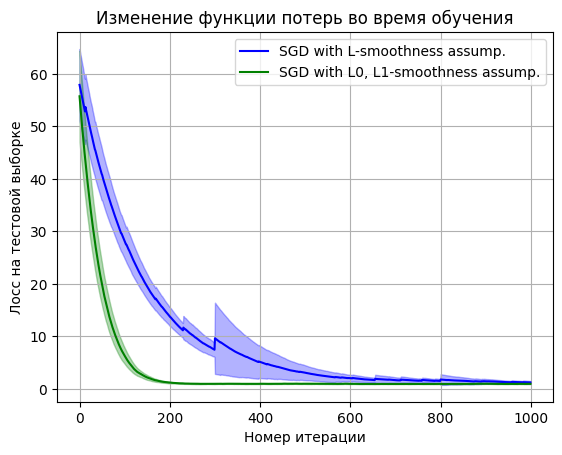

In [ ]:
plt.plot(sgd_mean, label='SGD with L-smoothness assump.', color='blue')
plt.fill_between(range(N_steps),sgd_mean - sgd_var, sgd_mean+sgd_var,alpha=0.3, edgecolor='blue', facecolor='blue')
plt.plot(sign_mean, label='SGD with L0, L1-smoothness assump.', color='green')
plt.fill_between(range(N_steps),sign_mean - sign_var, sign_mean+sign_var,alpha=0.3, edgecolor='green', facecolor='green')
plt.xlabel('Номер итерации')
plt.ylabel('Лосс на тестовой выборке')
plt.title('Изменение функции потерь во время обучения')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predict(w, X, y):
    return np.mean(jnp.sign(X @ w) == y_test)

In [ ]:
acc = partial(predict, X=X_test, y=y_test)

In [ ]:
def train2(alg, N_steps, repeats, gammal, gammal1, acc, loss):
    runs = np.zeros([N_steps,repeats])
    for rep in range(repeats):
        x = np.random.normal(size=d)
        f_values = []
        for step in range(N_steps):
            f_values.append(acc(x) * 100)
            if alg == 'sgd':
                update = stochastic_gradient((jax.grad(loss))(x))
                x -= gammal * update
            elif alg == 'signSGD':
                update = np.sign(stochastic_gradient((jax.grad(loss))(x)))
                x -= gammal1 * update
#             x -= lr/np.sqrt(step+1) * update
        runs[:,rep] = np.asarray(f_values)
    return runs

In [ ]:
N_steps = 500
repeats = 5
acc_sgd_runs = train2('sgd', N_steps=N_steps, repeats=repeats, gammal=gammal, gammal1=gammal1, acc=acc, loss=func2)
acc_signSGD_runs = train2('signSGD',N_steps=N_steps, repeats=repeats, gammal=gammal, gammal1=gammal1, acc=acc, loss=func2)

In [ ]:
acc_sgd_mean, acc_sgd_var = processRuns(acc_sgd_runs)
acc_sign_mean, acc_sign_var = processRuns(acc_signSGD_runs)

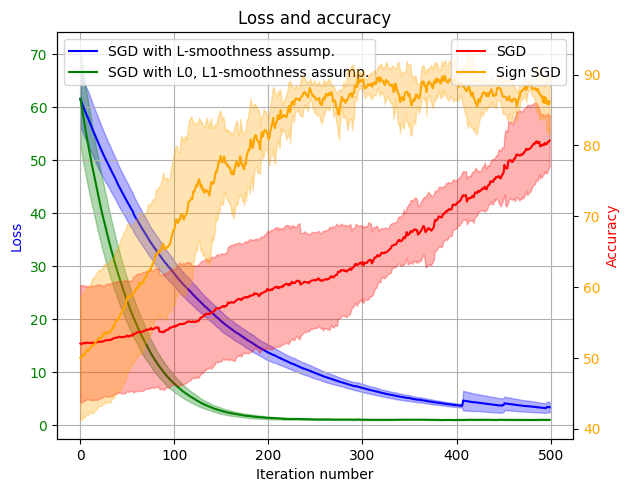

In [ ]:
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Iteration number')
ax1.set_ylabel('Loss', color=color)
ax1.plot(sgd_mean, label='SGD with L-smoothness assump.', color=color)
ax1.fill_between(range(N_steps), sgd_mean - sgd_var, sgd_mean + sgd_var, alpha=0.3, edgecolor=color, facecolor=color)
color = 'green'
ax1.plot(sign_mean, label='SGD with L0, L1-smoothness assump.', color=color)
ax1.fill_between(range(N_steps), sign_mean - sign_var, sign_mean + sign_var, alpha=0.3, edgecolor=color, facecolor=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_sgd_mean, label='SGD', color=color)
ax2.fill_between(range(N_steps), acc_sgd_mean - acc_sgd_var, acc_sgd_mean + acc_sgd_var, alpha=0.3, edgecolor=color, facecolor=color)
color = 'orange'
ax2.plot(acc_sign_mean, label='Sign SGD', color=color)
ax2.fill_between(range(N_steps), acc_sign_mean - acc_sign_var, acc_sign_mean + acc_sign_var, alpha=0.3, edgecolor=color, facecolor=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Loss and accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()


In [ ]:
class SignSGD_Momentum():
    def __init__(self, gamma, max_iter, x_start, func, noise_gen, beta=0.9):
        self.gamma = gamma
        self.max_iter = max_iter
        self.x_current = jnp.array(x_start, dtype=jnp.float64)
        self.func = func
        self.noise_gen = noise_gen  # функция генерации шума
        self.logger = []
        self.loss_logger = []
        self.beta = beta
        self.momentum = jnp.zeros_like(self.x_current)

    def compute_grad(self):
        grad_func = jax.grad(self.func)
        return grad_func(self.x_current)

    def step(self):
        grad = self.compute_grad() + self.noise_gen()
        self.momentum = self.beta * self.momentum + (1 - self.beta) * grad
        update = jnp.sign(self.momentum)
        self.x_current = self.x_current - self.gamma * update
        self.loss_logger.append(self.func(self.x_current))

    def run(self):
        self.logger.append(self.x_current.copy())
        self.loss_logger.append(self.func(self.x_current))
        for _ in range(self.max_iter):
            self.step()
            self.logger.append(self.x_current.copy())


In [ ]:
gamma_m = 0.1 / (8 * L1 * d)
gamma_m

np.float64(1.9992051869173217e-05)

In [ ]:
def processRuns(runs):
    mean = np.mean(runs,axis=1)
    std = np.std(runs,axis=1)
    return mean, std

In [ ]:
def train2(alg, N_steps, repeats, gammal, gammal1, acc, loss, beta=0.9, alpha=1.5, noise_scale=0.1):
    runs = np.zeros([N_steps, repeats])
    for rep in range(repeats):
        x = np.random.normal(size=d)
        m = np.zeros_like(x)  # для Momentum
        f_values = []

        for step in range(N_steps):
            f_values.append(acc(x) * 100)

            # Шум из Леви-стейбл распределения
            noise = levy_stable.rvs(alpha, 0, size=d) * noise_scale
            grad = np.array(jax.grad(loss)(x)) + noise

            if alg == 'sgd':
                x -= gammal * grad

            elif alg == 'signSGD':
                x -= gammal1 * np.sign(grad)

            elif alg == 'signSGDmomentum':
                m = beta * m + (1 - beta) * grad
                x -= gammal1 * np.sign(m)

            elif alg == 'SGDmomentum':
                m = beta * m + (1 - beta) * grad
                x -= gammal * m


        runs[:, rep] = np.asarray(f_values)

    return runs


In [ ]:
def train3(alg, N_steps, repeats, gammal, gammal1, acc, loss, beta=0.9, alpha=1.5, noise_scale=0.1):
    runs = np.zeros([N_steps, repeats])
    for rep in range(repeats):
        x = np.random.normal(size=d)
        m = np.zeros_like(x)  # для Momentum
        f_values = []

        for step in range(N_steps):
            f_values.append(loss(x))

            # Шум из Леви-стейбл распределения
            noise = levy_stable.rvs(alpha, 0, size=d) * noise_scale
            grad = np.array(jax.grad(loss)(x)) + noise

            if alg == 'sgd':
                x -= gammal * grad

            elif alg == 'signSGD':
                x -= gammal1 * np.sign(grad)

            elif alg == 'signSGDmomentum':
                m = beta * m + (1 - beta) * grad
                x -= gammal1 * np.sign(m)
            elif alg == 'SGDmomentum':
                m = beta * m + (1 - beta) * grad
                x -= gammal * m


        runs[:, rep] = np.asarray(f_values)

    return runs


In [ ]:
N_steps = 1000
repeats = 10
mom = train3('signSGDmomentum', N_steps=1000, repeats=10,
                       gammal=0.05, gammal1=0.01, acc=acc, loss=func2)

In [ ]:
mom_loss_mean, mom_loss_var = processRuns(mom)

In [ ]:
runs_momentum = train2('signSGDmomentum', N_steps=1000, repeats=10,
                       gammal=0.05, gammal1=0.01, acc=acc, loss=func2)
mom_mean, mom_var = processRuns(runs_momentum)


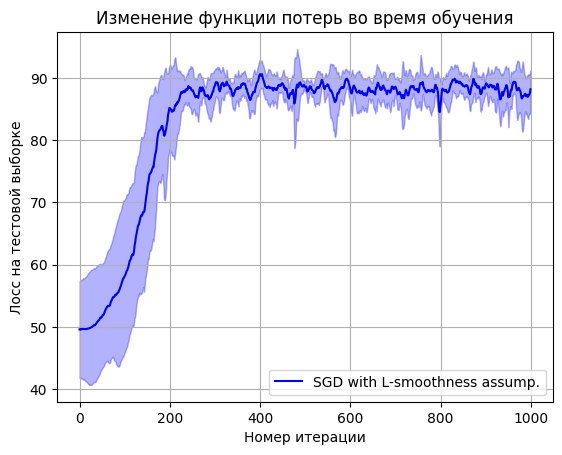

In [ ]:
plt.plot(mom_mean, label='SGD with L-smoothness assump.', color='blue')
plt.fill_between(range(1000),mom_mean - mom_var, mom_mean+mom_var,alpha=0.3, edgecolor='blue', facecolor='blue')
plt.xlabel('Номер итерации')
plt.ylabel('Лосс на тестовой выборке')
plt.title('Изменение функции потерь во время обучения')
plt.legend()
plt.grid(True)
plt.show()

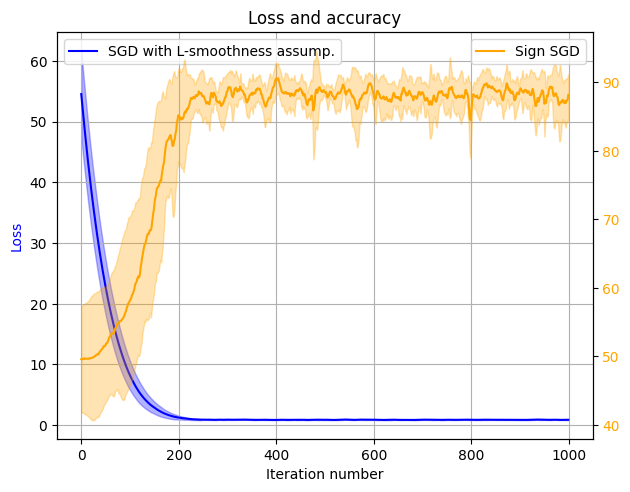

In [ ]:
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Iteration number')
ax1.set_ylabel('Loss', color=color)
ax1.plot(mom_loss_mean, label='SGD with L-smoothness assump.', color=color)
ax1.fill_between(range(1000),mom_loss_mean - mom_loss_var, mom_loss_mean+mom_loss_var,alpha=0.3, edgecolor='blue', facecolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.plot(mom_mean, label='Sign SGD', color=color)
ax2.fill_between(range(1000),mom_mean - mom_var, mom_mean+mom_var,alpha=0.3, edgecolor=color, facecolor=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Loss and accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()


In [ ]:
plt.plot(np.mean(runs_momentum, axis=1), label='SignSGD with Momentum')
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Convergence with SignSGD + Momentum")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
momsgd_loss = train3('SGDmomentum', N_steps=500, repeats=5,
                       gammal=0.01, gammal1=0.01, acc=acc, loss=func2)
momsgd_loss_mean, momsgd_loss_var = processRuns(momsgd_loss)
momsgd = train2('SGDmomentum', N_steps=500, repeats=5,
                       gammal=0.01, gammal1=0.01, acc=acc, loss=func2)
momsgd_mean, momsgd_var = processRuns(momsgd)


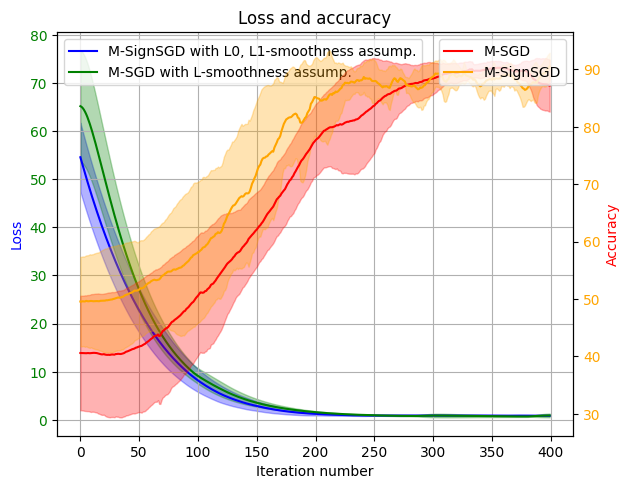

In [ ]:
fig, ax1 = plt.subplots()
N = 400
color = 'blue'
ax1.set_xlabel('Iteration number')
ax1.set_ylabel('Loss', color=color)
ax1.plot(mom_loss_mean[:N], label='M-SignSGD with L0, L1-smoothness assump.', color=color)
ax1.fill_between(range(N),(mom_loss_mean - mom_loss_var)[:N], (mom_loss_mean+mom_loss_var)[:N],alpha=0.3, edgecolor='blue', facecolor='blue')
color = 'green'
ax1.plot(momsgd_loss_mean[:N], label='M-SGD with L-smoothness assump.', color=color)
ax1.fill_between(range(N), (momsgd_loss_mean - momsgd_loss_var)[:N], (momsgd_loss_mean+momsgd_loss_var)[:N],alpha=0.3, edgecolor=color, facecolor=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(momsgd_mean[:N], label='M-SGD', color=color)
ax2.fill_between(range(N), (momsgd_mean - momsgd_var)[:N], (momsgd_mean+momsgd_var)[:N],alpha=0.3, edgecolor=color, facecolor=color)
color = 'orange'
ax2.plot(mom_mean[:N], label='M-SignSGD', color=color)
ax2.fill_between(range(N),(mom_mean - mom_var)[:N], (mom_mean+mom_var)[:N],alpha=0.3, edgecolor=color, facecolor=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Loss and accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()



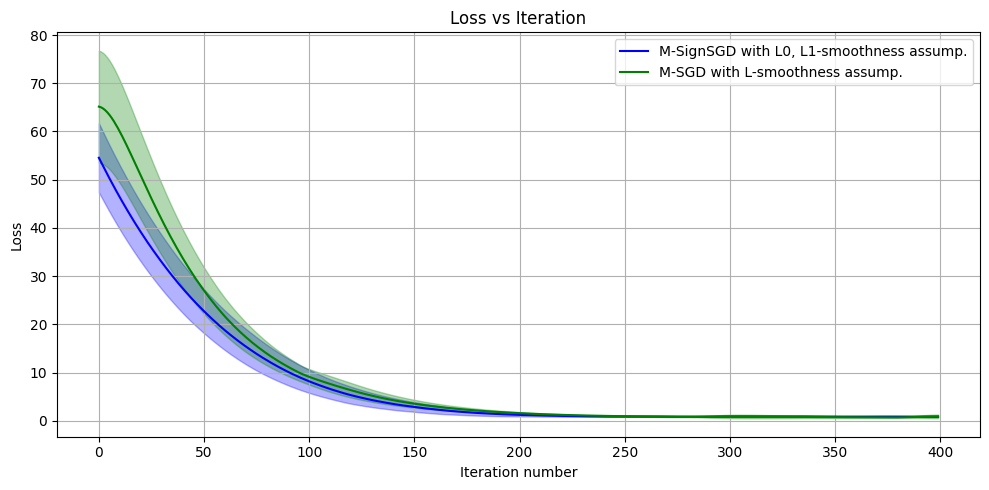

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
N = 400

# Loss: M-SignSGD
ax.plot(mom_loss_mean[:N], label='M-SignSGD with L0, L1-smoothness assump.', color='blue')
ax.fill_between(range(N),
                (mom_loss_mean - mom_loss_var)[:N],
                (mom_loss_mean + mom_loss_var)[:N],
                alpha=0.3, edgecolor='blue', facecolor='blue')

# Loss: M-SGD
ax.plot(momsgd_loss_mean[:N], label='M-SGD with L-smoothness assump.', color='green')
ax.fill_between(range(N),
                (momsgd_loss_mean - momsgd_loss_var)[:N],
                (momsgd_loss_mean + momsgd_loss_var)[:N],
                alpha=0.3, edgecolor='green', facecolor='green')

ax.set_xlabel('Iteration number')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Iteration')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


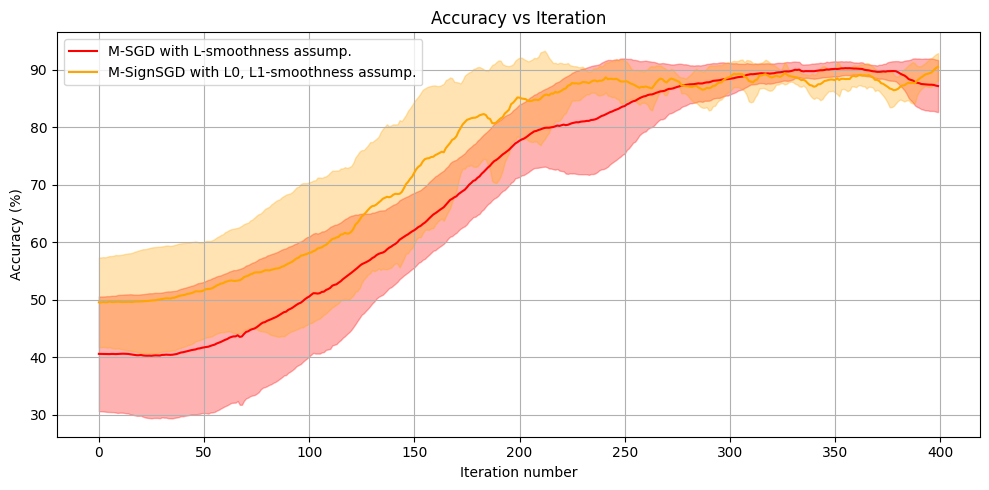

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
N = 400

# Accuracy: M-SGD
ax.plot(momsgd_mean[:N], label='M-SGD with L-smoothness assump.', color='red')
ax.fill_between(range(N),
                (momsgd_mean - momsgd_var)[:N],
                (momsgd_mean + momsgd_var)[:N],
                alpha=0.3, edgecolor='red', facecolor='red')

# Accuracy: M-SignSGD
ax.plot(mom_mean[:N], label='M-SignSGD with L0, L1-smoothness assump.', color='orange')
ax.fill_between(range(N),
                (mom_mean - mom_var)[:N],
                (mom_mean + mom_var)[:N],
                alpha=0.3, edgecolor='orange', facecolor='orange')

ax.set_xlabel('Iteration number')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy vs Iteration')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

import pandas as pd
# Примерные данные, которые ты можешь заменить на реальные результаты из эксперимента
methods = ['M-SignSGD', 'M-SGD', 'SignSGD', 'SGD']
loss_mean = [np.mean(mom_loss_mean), np.mean(momsgd_loss_mean), np.mean(sign_mean), np.mean(sgd_mean)]
accuracy_mean = [np.mean(mom_mean), np.mean(momsgd_mean), np.mean(acc_sign_mean), np.mean(acc_sgd_mean)]
convergence_rate = np.abs([np.mean(np.diff(mom_loss_mean)), np.mean(np.diff(momsgd_loss_mean)),
                    np.mean(np.diff(sign_mean)), np.mean(np.diff(sgd_mean))])
loss_variance = [np.var(mom_loss_mean), np.var(momsgd_loss_mean), np.var(sign_mean), np.var(sgd_mean)]
accuracy_variance = [np.var(mom_mean), np.var(momsgd_mean), np.var(acc_sign_mean), np.var(acc_sgd_mean)]

# Создаем DataFrame для сравнения методов
comparison_table = pd.DataFrame({
    'Method': methods,
    'Mean Loss': loss_mean,
    'Mean Accuracy (%)': accuracy_mean,
    'Convergence Rate': convergence_rate,
    'Loss Variance': loss_variance,
    'Accuracy Variance': accuracy_variance
})

# Выводим таблицу
import numpy as np
comparison_table

,Method,Mean Loss,Mean Accuracy (%),Convergence Rate,Loss Variance,Accuracy Variance
0,M-SignSGD,3.636586,82.868848,0.053725,73.560639,135.770756
1,M-SGD,7.729881,73.468356,0.128940,209.468179,341.586038
2,SignSGD,6.717110,79.121894,0.121547,155.107155,140.471160
3,SGD,16.446888,62.961501,0.116584,234.206647,70.554852


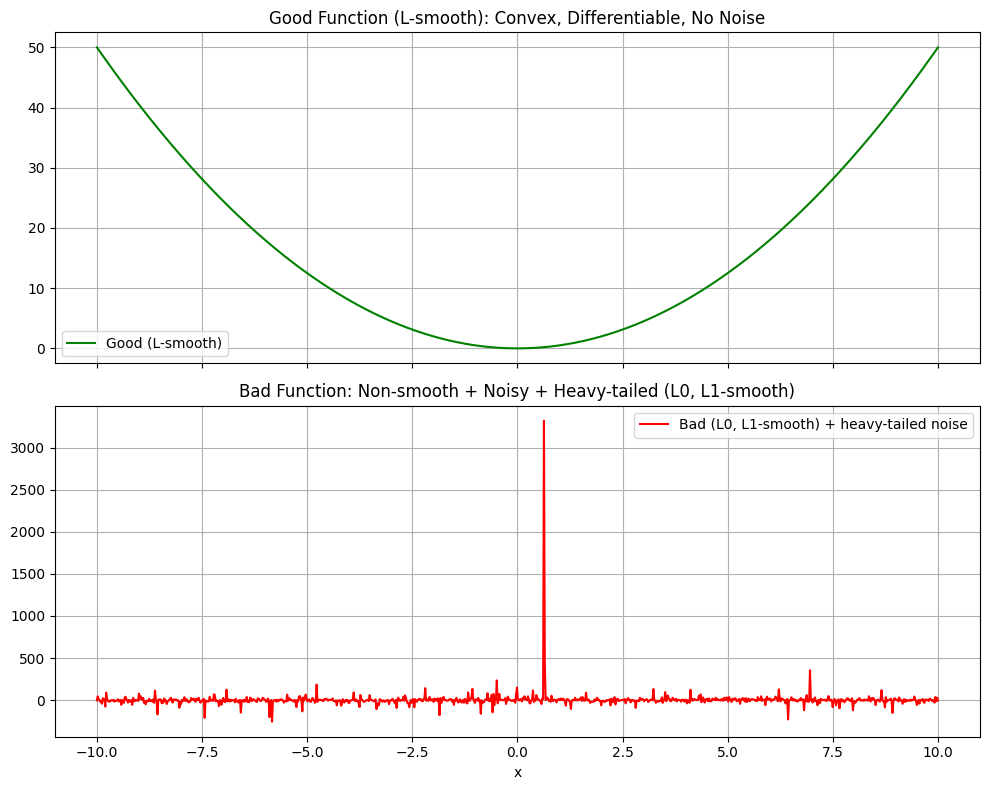

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable

# "Хорошая" функция: квадратичная
def good_function(x):
    return 0.5 * x**2

# "Плохая" функция: кусок функции Швеффеля + шум с тяжёлыми хвостами
def bad_function(x):
    base = x * np.sin(np.sqrt(np.abs(x)))  # из функции Швеффеля (де Йонга)
    noise = levy_stable.rvs(alpha=1.2, beta=0, size=len(x)) * 10  # heavy-tailed noise
    return base + noise

x = np.linspace(-10, 10, 1000)

# Для воспроизводимости
np.random.seed(42)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Гладкая
axs[0].plot(x, good_function(x), color='green', label='Good (L-smooth)')
axs[0].set_title("Good Function (L-smooth): Convex, Differentiable, No Noise")
axs[0].legend()
axs[0].grid(True)

# Плохая
axs[1].plot(x, bad_function(x), color='red', label='Bad (L0, L1-smooth) + heavy-tailed noise')
axs[1].set_title("Bad Function: Non-smooth + Noisy + Heavy-tailed (L0, L1-smooth)")
axs[1].legend()
axs[1].grid(True)

plt.xlabel("x")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm

# Set dimension
d = 10

# Define the "bad" convex function
def bad_func(x):
    return jnp.linalg.norm(x)**4

# Define the accuracy metric: how close x is to 0
def acc(x):
    return 1. / (1. + jnp.linalg.norm(x))

# Heavy-tailed noise: Student's t-distribution with df in (1,2]
def stochastic_gradient(grad):
    noise = np.random.standard_t(df=1.5, size=grad.shape)
    return grad + noise

# Training function
def train2(alg, N_steps, repeats, gammal, gammal1, acc, loss):
    runs_acc = np.zeros([N_steps, repeats])
    runs_loss = np.zeros([N_steps, repeats])
    for rep in tqdm(range(repeats), desc=f"Running {alg}"):
        x = np.random.normal(size=d)
        for step in range(N_steps):
            runs_acc[step, rep] = acc(x) * 100
            runs_loss[step, rep] = loss(x)
            grad = (jax.grad(loss))(x)
            if alg == 'gd':
                update = stochastic_gradient(grad)
                x -= gammal * update
            elif alg == 'signSGD':
                update = np.sign(stochastic_gradient(grad))
                x -= gammal1 * update
        # Final loss & acc for reporting
        runs_acc[:, rep] = np.asarray(runs_acc[:, rep])
        runs_loss[:, rep] = np.asarray(runs_loss[:, rep])
    return runs_acc, runs_loss

# Run experiments
N_steps = 200
repeats = 30
gamma_gd = 0.001
gamma_sign = 0.01

# Run GD
gd_acc, gd_loss = train2('gd', N_steps, repeats, gamma_gd, gamma_sign, acc, bad_func)

# Run SignSGD
sign_acc, sign_loss = train2('signSGD', N_steps, repeats, gamma_gd, gamma_sign, acc, bad_func)

# Plotting results
def plot_metric(gd_metric, sign_metric, ylabel, title):
    fig, ax = plt.subplots()
    mean_gd = np.mean(gd_metric, axis=1)
    var_gd = np.std(gd_metric, axis=1)
    mean_sign = np.mean(sign_metric, axis=1)
    var_sign = np.std(sign_metric, axis=1)

    ax.plot(mean_gd, label='GD', color='red')
    ax.fill_between(range(N_steps), mean_gd - var_gd, mean_gd + var_gd, alpha=0.2, color='red')

    ax.plot(mean_sign, label='SignSGD', color='blue')
    ax.fill_between(range(N_steps), mean_sign - var_sign, mean_sign + var_sign, alpha=0.2, color='blue')

    ax.set_xlabel("Iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.show()

plot_metric(gd_loss, sign_loss, "Loss", "Comparison of GD and SignSGD on $||x||^4$ (Loss)")
plot_metric(gd_acc, sign_acc, "Accuracy (%)", "Comparison of GD and SignSGD on $||x||^4$ (Accuracy)")
